In [1]:
include("grid_world_core.jl")
using Flux
using Zygote
using Plots


(process:19484): GLib-GIO-WARNING **: 12:30:42.705: Unexpectedly, UWP app `Evernote.Evernote_10.36.4.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs


In [3]:
#Intialize world
r = zeros(6,8)
blocked = [4 2]
blocked = [4 2; 4 3; 4 4; 4 5; 4 6; 4 7; 4 8]
start = [6; 4]
goal = [1; 8]
r[goal[1],goal[2]] = 1

world1 = World(copy(r), copy(blocked), start, goal, size(r))
plot_world(world1)

['□', '□', '□', '□', '□', '□', '□', 'Ⓖ']
['□', '□', '□', '□', '□', '□', '□', '□']
['□', '□', '□', '□', '□', '□', '□', '□']
['□', '■', '■', '■', '■', '■', '■', '■']
['□', '□', '□', '□', '□', '□', '□', '□']
['□', '□', '□', 'ⓢ', '□', '□', '□', '□']


In [2]:
function pick_a(prob)
    selector=rand()
    a=1
    while selector-prob[a]>0
        selector-=prob[a]
        a+=1
    end
    return a
end

pick_a (generic function with 1 method)

In [4]:
# Discount
gamma = 0.9 
# Learning rate not needed for tabular MC but slows convergence and makes incrmental improvement more visible 
# for demonstration also smaller alpha increases amount of time spent exploring vs exploiting
alpha = 0.1 
Nepisode = 5000;

In [5]:
#Intialize q and environment
q=zeros(world1.size[1],world1.size[2],4)
sampled=zeros(world1.size[1],world1.size[2],4)
world = world1
update_time = 0
num_steps_fromStart=[]

for e = 1:Nepisode
    # intialize episode and trejectory history
    iter = 0
    goal_reached = false
    s=copy(world.start)
    h_ret=Int[]
    h_states=[]
    h_act=Int[]
    
    #Play an episode
    while(!goal_reached && iter < 1000)
        # pick action according to softmax probabilities
        prob=softmax(q[s[1],s[2],:])
        a=pick_a(prob)
        
        #Apply action and compute reward
        s_new, r = transition(s, a, world)
        if s_new==s
            r=-1 # neg reward for illegal action
        end
        if r>0
            r=r*10 # large reward r=10 for goal state 
        end

        # Add state, action, and reward to episode trajectory
        s_tuple=(s[1],s[2])
        push!( h_states, s_tuple )
        append!( h_act, a )
        append!( h_ret, r )
        

        #terminate episode if goal reached
        if s_new == world.goal
            goal_reached = true
        end
        
        s = copy(s_new)
        #a = copy(a_new)
        iter += 1
        update_time += 1
    end

    
    
    # Update Q from sampled trajectory
    SxA=Set()
    g=0
    for i=size(h_ret,1):-1:1
        g = gamma*g + h_ret[i]
        if !((h_states[i][1],h_states[i][2],h_act[i]) in SxA)
            samp = sampled[h_states[i][1],h_states[i][2],h_act[i]]
            if samp==0
                samp=1
            end
            q[h_states[i][1],h_states[i][2],h_act[i]] = (q[h_states[i][1],h_states[i][2],h_act[i]]*samp+g*alpha)/(samp) # runnning avg attempt
            sampled[h_states[i][1],h_states[i][2],h_act[i]]+=1
            push!(SxA,(h_states[i][1],h_states[i][2],h_act[i]))
        end
    end


    
    # Track number of steps until termination
    append!(num_steps_fromStart,iter)
    # Plot current optimal policy every 500 episodes
    if e%500==1
        plot_optimal_action(q, world)
    end
end

['→', '↓', '→', '→', '→', '→', '→', 'Ⓖ']
['→', '→', '↑', '•', '•', '•', '•', '•']
['•', '↑', '•', '•', '•', '•', '•', '•']
['↑', '■', '■', '■', '■', '■', '■', '■']
['↓', '←', '↓', '•', '•', '•', '•', '•']
['→', '→', '↑', '•', '•', '•', '•', '•']
['→', '→', '→', '→', '→', '→', '→', 'Ⓖ']
['→', '→', '↑', '→', '→', '→', '↑', '↑']
['→', '↑', '→', '↑', '→', '→', '↑', '←']
['↑', '■', '■', '■', '■', '■', '■', '■']
['↑', '←', '↓', '←', '←', '↓', '←', '←']
['→', '↑', '→', '→', '↑', '←', '←', '←']
['→', '→', '→', '→', '→', '→', '→', 'Ⓖ']
['→', '→', '↑', '→', '→', '→', '↑', '↑']
['→', '↑', '→', '↑', '→', '→', '↑', '←']
['↑', '■', '■', '■', '■', '■', '■', '■']
['↑', '←', '←', '←', '←', '↓', '←', '←']
['→', '↑', '←', '→', '↑', '←', '←', '←']
['→', '→', '→', '→', '→', '→', '→', 'Ⓖ']
['→', '→', '↑', '→', '→', '→', '↑', '↑']
['→', '↑', '→', '↑', '→', '↑', '↑', '←']
['↑', '■', '■', '■', '■', '■', '■', '■']
['↑', '←', '←', '←', '←', '↓', '←', '←']
['→', '↑', '←', '→', '↑', '←', '←', '←']
['→', '→', '→', 

### Plot of average number of steps to reach goal state

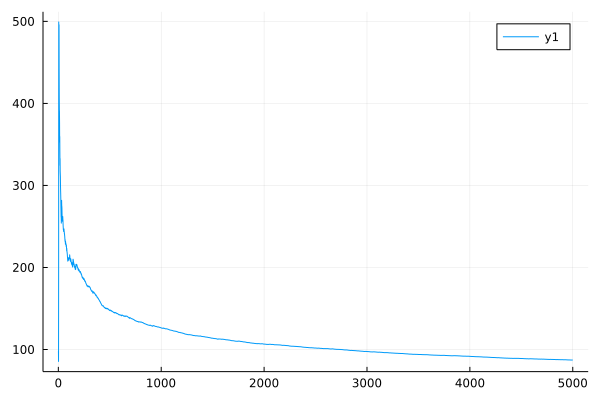

In [6]:
avg_steps2=[]
s=0
for i=1:size(num_steps_fromStart,1)
    s+=num_steps_fromStart[i]
    push!(avg_steps2,s/i)
end
plot(avg_steps2)